Value of Commercial Product Sales Data in Healthcare Prediction

Author: Elizabeth Dolan Date: 19 November 2021

This code can be used to create an optimised random forest regressor (using a time series cross validation grid search) that can be evaluated using Model Class Reliance (code for running MCR in separate file). This code can be used and adapted to create baseline model and final models.

Code below does the following:
-Imports some key packages -Creates dataframe from csv -Checks and describes the dataframe -Changes date to correct date format within python -Assigns y (the target - varaible the model needs to predict) -Assigns X (the features- variables inputted in order to predict y) -Splits data into training and test data (here we also split data to test separately on data from the pandemic timeframe). Data is manually split to prevent dataleakage as dataframe contains timeseries data with multiple entries from each date for different geographic areas. -Time series split (data) for cross validation (Time series cross validation). Manually checked, again to prevent data leakage. -Cross validation grid search to find optimum hyperparameters for random forest regressor (remembering bootstrap parameter has to be set to False in order for MCR package to work later) -Scores for R2, RSME and MAE on test data using model from grid search -Create optimised random forest regressor model using parameters given by grid search "op_rf" -Scores for R2, RSME and MAE on training data, test data, covid test data, and full dataset -Scatter Plot full dataset, showing predictions and targets -Line plots showing (1)predictions (2) predictions and actual targets -Plots feature importance using the following variable importance tools: random forest, permutation, SHAP

In [71]:
#Imports some key packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
#Creates dataframe from csv
#fyi in this analysis imported csv is sorted by date - this data order is needed in order for data splitting without leakage later on
df = pd.read_csv('padrus_data_weather.csv')

In [73]:
#how many rows and columns in data
df.shape

(85094, 89)

In [74]:
# how many ltla's (lower tier local authorities)
df['ltla_code.1'].value_counts()

E07000151    271
E06000040    271
E07000165    271
E07000208    271
E07000103    271
            ... 
E07000153    271
E07000139    271
E07000116    271
E09000028    271
E07000142    271
Name: ltla_code.1, Length: 314, dtype: int64

In [5]:
#how many dates (and for each ltla)
df['date'].value_counts()

2019-01-18    314
2020-08-21    314
2019-09-27    314
2017-09-01    314
2018-11-16    314
             ... 
2020-07-03    314
2019-11-15    314
2020-04-17    314
2017-09-29    314
2019-12-13    314
Name: date, Length: 271, dtype: int64

In [6]:
#describes dataframe
df.describe()

,weeknum,year,cnt,ltla_week_sales_17,cough_all_17,cough_dry_17,cough_mucus_17,decongestant_17,throat_17,pain_relief_17,...,pct_other_children,pct_detached,pct_semi,pct_terraced,pct_flat,average_rainfall,total_rainfall,min_temp,average_temp,max_temp
count,85094.000000,85094.000000,85094.000000,8.509400e+04,8.509400e+04,8.509400e+04,85094.000000,8.509400e+04,8.509400e+04,8.509400e+04,...,85094.00000,85094.000000,85094.000000,85094.000000,85094.000000,8.509400e+04,8.509400e+04,85094.000000,85094.000000,85094.000000
mean,26.073801,2018.306273,10.367793,2.532846e+04,1.689898e+02,1.600280e+02,14.215717,1.642078e+02,9.990791e+01,1.432223e+03,...,2.40801,25.419331,30.783631,23.550494,19.722404,1.309863e-03,8.840115e-03,284.759643,284.979610,285.176374
std,14.859642,1.541058,8.093897,2.822034e+04,2.227247e+02,2.132025e+02,20.970945,2.264914e+02,1.567528e+02,1.541813e+03,...,1.17110,12.724138,8.493608,8.620912,15.244534,1.260302e-03,1.597105e-02,5.447700,5.444373,5.447407
min,1.000000,2016.000000,0.000000,2.810000e-140,6.070000e-143,4.150000e-157,0.000000,1.820000e-142,9.710000e-143,1.500000e-141,...,0.80000,0.400000,0.200000,1.400000,4.300000,1.650000e-07,2.860000e-07,271.025086,272.453941,273.023241
25%,13.000000,2017.000000,5.000000,8.391937e+03,4.644477e+01,4.201779e+01,3.183839,5.073555e+01,2.499274e+01,5.289498e+02,...,1.70000,14.300000,27.300000,17.600000,10.700000,3.511558e-04,1.076757e-03,280.392076,280.576018,280.758090
50%,25.000000,2018.000000,8.000000,1.666741e+04,9.741878e+01,9.125376e+01,7.623754,9.733546e+01,5.226928e+01,9.819091e+02,...,2.00000,26.650000,30.750000,22.350000,15.350000,9.387455e-04,3.507894e-03,284.165607,284.384763,284.575601
75%,39.000000,2020.000000,12.000000,3.121967e+04,1.999798e+02,1.899791e+02,16.171289,1.849534e+02,1.091181e+02,1.698395e+03,...,2.50000,36.100000,35.600000,28.200000,22.900000,1.922062e-03,9.978107e-03,289.526492,289.758587,289.966649
max,52.000000,2021.000000,219.000000,3.018210e+05,4.772230e+03,4.279016e+03,418.271522,4.752941e+03,3.613782e+03,3.573777e+04,...,10.50000,55.200000,48.800000,56.100000,98.000000,1.091118e-02,4.043763e-01,301.994277,302.015021,302.035765


In [7]:
#sums total sales
df['ltla_week_sales_17'].sum()

2155300393.4527617

In [80]:
#sums total cough sales (17 days in advance)
df['cough_all_17'].sum()

14380021.831650492

In [8]:
#sums deaths from respiratory disease
df['cnt'].sum()

882237

In [9]:
#check start of data incl. start date
df.head()

,weeknum,year,date,ltla_code,cnt,ltla_code.1,ltla_name,sales_week,ltla_week_sales_17,cough_all_17,...,nhser20cd,nhser20cdh,nhser20nm,rain_date,average_rainfall,total_rainfall,temp_date,min_temp,average_temp,max_temp
0,11,2016,2016-03-18,E06000001,9,E06000001,Hartlepool,02/03/2016,8296.401630,85.051700,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001205,0.002411,02/03/2016,277.682652,277.754066,277.825480
1,11,2016,2016-03-18,E06000002,12,E06000002,Middlesbrough,02/03/2016,21849.491460,256.413899,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001247,0.013712,02/03/2016,276.422226,277.390071,277.921991
2,11,2016,2016-03-18,E06000003,10,E06000003,Redcar and Cleveland,02/03/2016,8230.842884,133.180292,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001265,0.002531,02/03/2016,277.128385,277.525188,277.921991
3,11,2016,2016-03-18,E06000004,9,E06000004,Stockton-on-Tees,02/03/2016,13955.144380,173.160904,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001249,0.006247,02/03/2016,277.573643,277.728908,277.894533
4,11,2016,2016-03-18,E06000005,7,E06000005,Darlington,02/03/2016,8417.344575,108.039090,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001392,0.002784,02/03/2016,277.081158,277.275305,277.469452


In [10]:
#check end of data incl. end date
df.tail()

,weeknum,year,date,ltla_code,cnt,ltla_code.1,ltla_name,sales_week,ltla_week_sales_17,cough_all_17,...,nhser20cd,nhser20cdh,nhser20nm,rain_date,average_rainfall,total_rainfall,temp_date,min_temp,average_temp,max_temp
85089,21,2021,2021-05-21,E09000029,8,E09000029,Sutton,05/05/2021,31515.54564,92.812856,...,E40000003,Y56,London,05/05/2021,0.000295,0.002945,05/05/2021,282.511554,282.866511,283.178683
85090,21,2021,2021-05-21,E09000030,5,E09000030,Tower Hamlets,05/05/2021,61145.96518,148.931846,...,E40000003,Y56,London,05/05/2021,0.000282,0.002822,05/05/2021,282.789753,283.061889,283.260263
85091,21,2021,2021-05-21,E09000031,7,E09000031,Waltham Forest,05/05/2021,21553.51423,71.789017,...,E40000003,Y56,London,05/05/2021,0.000280,0.000280,05/05/2021,283.151196,283.151196,283.151196
85092,21,2021,2021-05-21,E09000032,6,E09000032,Wandsworth,05/05/2021,71302.51527,193.038393,...,E40000003,Y56,London,05/05/2021,0.000273,0.002729,05/05/2021,282.789753,283.086641,283.260263
85093,21,2021,2021-05-21,E09000033,5,E09000033,Westminster,05/05/2021,106555.17060,225.788247,...,E40000003,Y56,London,05/05/2021,0.000267,0.002400,05/05/2021,282.858710,283.064914,283.260263


In [11]:
#change date column data to 'datetime' data type
df['date'] = pd.to_datetime(df['date'])

In [12]:
# check date change
df.head()

,weeknum,year,date,ltla_code,cnt,ltla_code.1,ltla_name,sales_week,ltla_week_sales_17,cough_all_17,...,nhser20cd,nhser20cdh,nhser20nm,rain_date,average_rainfall,total_rainfall,temp_date,min_temp,average_temp,max_temp
0,11,2016,2016-03-18,E06000001,9,E06000001,Hartlepool,02/03/2016,8296.401630,85.051700,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001205,0.002411,02/03/2016,277.682652,277.754066,277.825480
1,11,2016,2016-03-18,E06000002,12,E06000002,Middlesbrough,02/03/2016,21849.491460,256.413899,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001247,0.013712,02/03/2016,276.422226,277.390071,277.921991
2,11,2016,2016-03-18,E06000003,10,E06000003,Redcar and Cleveland,02/03/2016,8230.842884,133.180292,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001265,0.002531,02/03/2016,277.128385,277.525188,277.921991
3,11,2016,2016-03-18,E06000004,9,E06000004,Stockton-on-Tees,02/03/2016,13955.144380,173.160904,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001249,0.006247,02/03/2016,277.573643,277.728908,277.894533
4,11,2016,2016-03-18,E06000005,7,E06000005,Darlington,02/03/2016,8417.344575,108.039090,...,E40000009,Y63,North East and Yorkshire,02/03/2016,0.001392,0.002784,02/03/2016,277.081158,277.275305,277.469452


In [13]:
# check date change
df.tail()

,weeknum,year,date,ltla_code,cnt,ltla_code.1,ltla_name,sales_week,ltla_week_sales_17,cough_all_17,...,nhser20cd,nhser20cdh,nhser20nm,rain_date,average_rainfall,total_rainfall,temp_date,min_temp,average_temp,max_temp
85089,21,2021,2021-05-21,E09000029,8,E09000029,Sutton,05/05/2021,31515.54564,92.812856,...,E40000003,Y56,London,05/05/2021,0.000295,0.002945,05/05/2021,282.511554,282.866511,283.178683
85090,21,2021,2021-05-21,E09000030,5,E09000030,Tower Hamlets,05/05/2021,61145.96518,148.931846,...,E40000003,Y56,London,05/05/2021,0.000282,0.002822,05/05/2021,282.789753,283.061889,283.260263
85091,21,2021,2021-05-21,E09000031,7,E09000031,Waltham Forest,05/05/2021,21553.51423,71.789017,...,E40000003,Y56,London,05/05/2021,0.000280,0.000280,05/05/2021,283.151196,283.151196,283.151196
85092,21,2021,2021-05-21,E09000032,6,E09000032,Wandsworth,05/05/2021,71302.51527,193.038393,...,E40000003,Y56,London,05/05/2021,0.000273,0.002729,05/05/2021,282.789753,283.086641,283.260263
85093,21,2021,2021-05-21,E09000033,5,E09000033,Westminster,05/05/2021,106555.17060,225.788247,...,E40000003,Y56,London,05/05/2021,0.000267,0.002400,05/05/2021,282.858710,283.064914,283.260263


In [14]:
# check date change
dc = df['date'].unique()
len(dc)

271

In [15]:
# check date change
df.dtypes

weeknum                    int64
year                       int64
date              datetime64[ns]
ltla_code                 object
cnt                        int64
                       ...      
total_rainfall           float64
temp_date                 object
min_temp                 float64
average_temp             float64
max_temp                 float64
Length: 89, dtype: object

In [18]:
#assign data to y target
y = df['cnt']

In [19]:
#check y
y

0         9
1        12
2        10
3         9
4         7
         ..
85089     8
85090     5
85091     7
85092     6
85093     5
Name: cnt, Length: 85094, dtype: int64

In [20]:
#assign data to X features
X = df[['weeknum', 'ltla_week_sales_17', 'decongestant_17', 'throat_17', 
        'cough_dry_17','cough_all_17','ltla_week_sales_24', 'decongestant_24',
        'throat_24', 'cough_dry_24', 'cough_all_24', 'decongestant_lr',
        'throat_lr', 'cough_dry_lr', 'cough_all_lr', 'decongestant_m',
        'throat_m', 'cough_dry_m', 'cough_all_m', 'liv_env_score', 'crime_score', 
        'housing_score', 'pop_16to24', 'pop_25to49', 'pop_50to64', 'pop_over65', 'pop_density', 'pct_male', 
        'pct_female', 'imd_rank', 'imd_score', 'imd_extent', 'imd_concentration', 'pct_pre1919', 'pct_pre1940', 
        'pct_pre1973', 'pct_pre1983', 'pct_community', 'pct_industrial', 'pct_residential', 'pct_transport', 
        'pct_agriculture', 'pct_natural', 'pct_recreation', 'pct_non_white', 'pct_lone_parent', 
        'pct_other_children', 'pct_detached', 'pct_semi', 'pct_terraced', 'pct_flat', 'average_rainfall',
        'total_rainfall', 'min_temp', 'average_temp', 'max_temp']] 

In [26]:
# check X
X

,weeknum,ltla_week_sales_17,decongestant_17,throat_17,cough_dry_17,cough_all_17,ltla_week_sales_24,decongestant_24,throat_24,cough_dry_24,...,pct_other_children,pct_detached,pct_semi,pct_terraced,pct_flat,average_rainfall,total_rainfall,min_temp,average_temp,max_temp
0,11,8296.401630,60.951795,49.003973,82.070887,85.051700,1085.024334,12.990530,10.009475,18.014211,...,1.9,16.5,32.6,37.4,13.2,0.001205,0.002411,277.682652,277.754066,277.825480
1,11,21849.491460,152.990147,84.019829,265.271962,256.413899,2931.794440,19.774063,28.323537,46.676352,...,3.0,13.6,39.9,32.9,13.6,0.001247,0.013712,276.422226,277.390071,277.921991
2,11,8230.842884,86.469893,37.197905,128.478220,133.180292,1106.729835,15.014149,6.891967,26.483082,...,1.7,17.9,44.0,28.0,10.0,0.001265,0.002531,277.128385,277.525188,277.921991
3,11,13955.144380,112.765189,72.603180,176.998539,173.160904,1934.574040,16.578400,12.985567,39.067087,...,2.5,24.2,41.0,23.5,11.1,0.001249,0.006247,277.573643,277.728908,277.894533
4,11,8417.344575,58.022368,44.011362,110.044438,108.039090,1097.349338,14.001466,7.000009,26.012431,...,1.7,17.2,37.5,31.2,14.1,0.001392,0.002784,277.081158,277.275305,277.469452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85089,21,31515.545640,146.247831,59.834563,106.777311,92.812856,25306.162180,107.306003,39.487011,73.973071,...,3.0,10.7,28.1,25.7,35.4,0.000295,0.002945,282.511554,282.866511,283.178683
85090,21,61145.965180,331.586431,129.141055,166.342419,148.931846,47890.727610,261.476932,88.395759,126.374831,...,4.5,1.2,2.5,10.4,85.9,0.000282,0.002822,282.789753,283.061889,283.260263
85091,21,21553.514230,130.798666,37.497195,82.650236,71.789017,16833.534890,94.047276,22.245126,69.144611,...,6.2,4.6,16.9,37.2,41.2,0.000280,0.000280,283.151196,283.151196,283.151196
85092,21,71302.515270,387.443762,150.609209,202.331278,193.038393,58988.458060,336.247316,112.212746,173.233524,...,2.9,2.5,7.4,24.2,65.9,0.000273,0.002729,282.789753,283.086641,283.260263


In [27]:
#used to check manually selected data rows for split are correct
df.loc[45843]

weeknum                            52
year                             2018
date              2018-12-28 00:00:00
ltla_code                   E09000033
cnt                                 5
                         ...         
total_rainfall             0.00989938
temp_date                  12/12/2018
min_temp                      281.041
average_temp                  281.161
max_temp                      281.283
Name: 45843, Length: 89, dtype: object

In [28]:
df.loc[45844]

weeknum                             1
year                             2019
date              2019-01-04 00:00:00
ltla_code                   E06000001
cnt                                 5
                         ...         
total_rainfall             0.00180199
temp_date                  19/12/2018
min_temp                      277.997
average_temp                  278.118
max_temp                      278.239
Name: 45844, Length: 89, dtype: object

In [29]:
# data split into train and test data, extra covid test set

X_train = X.iloc[:45844,:]
X_test = X.iloc[45844:66254,:]
X_covid_test = X.iloc[66254:,:] #covid period
y_train = y.iloc[:45844,]
y_test = y.iloc[45844:66254,]
y_covid_test = y.iloc[66254:,] #covid period


In [57]:
#check training data
X_train

,weeknum,ltla_week_sales_17,decongestant_17,throat_17,cough_dry_17,cough_all_17,ltla_week_sales_24,decongestant_24,throat_24,cough_dry_24,...,pct_other_children,pct_detached,pct_semi,pct_terraced,pct_flat,average_rainfall,total_rainfall,min_temp,average_temp,max_temp
0,11,8296.401630,60.951795,49.003973,82.070887,85.051700,1085.024334,12.990530,10.009475,18.014211,...,1.9,16.5,32.6,37.4,13.2,0.001205,0.002411,277.682652,277.754066,277.825480
1,11,21849.491460,152.990147,84.019829,265.271962,256.413899,2931.794440,19.774063,28.323537,46.676352,...,3.0,13.6,39.9,32.9,13.6,0.001247,0.013712,276.422226,277.390071,277.921991
2,11,8230.842884,86.469893,37.197905,128.478220,133.180292,1106.729835,15.014149,6.891967,26.483082,...,1.7,17.9,44.0,28.0,10.0,0.001265,0.002531,277.128385,277.525188,277.921991
3,11,13955.144380,112.765189,72.603180,176.998539,173.160904,1934.574040,16.578400,12.985567,39.067087,...,2.5,24.2,41.0,23.5,11.1,0.001249,0.006247,277.573643,277.728908,277.894533
4,11,8417.344575,58.022368,44.011362,110.044438,108.039090,1097.349338,14.001466,7.000009,26.012431,...,1.7,17.2,37.5,31.2,14.1,0.001392,0.002784,277.081158,277.275305,277.469452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45839,52,42065.362410,340.440086,254.221812,451.450962,414.255641,38058.030810,280.231918,201.298232,412.257650,...,3.0,10.7,28.1,25.7,35.4,0.001115,0.011147,280.749412,281.026606,281.267717
45840,52,149257.735300,1810.934856,1595.237792,1608.070369,1712.833226,144489.460800,1601.042438,1431.483957,1444.085336,...,4.5,1.2,2.5,10.4,85.9,0.001072,0.010724,280.956533,281.162689,281.275096
45841,52,30763.413200,320.247782,187.410045,462.962119,414.962344,28480.581840,291.572256,191.033895,334.099822,...,6.2,4.6,16.9,37.2,41.2,0.001057,0.001057,281.204763,281.204763,281.204763
45842,52,103516.544300,1135.101564,858.406706,1139.719624,1181.069496,97769.613620,991.677009,785.701466,1002.010559,...,2.9,2.5,7.4,24.2,65.9,0.001108,0.011080,280.956533,281.184430,281.300402


In [30]:
#check testing data
X_test

,weeknum,ltla_week_sales_17,decongestant_17,throat_17,cough_dry_17,cough_all_17,ltla_week_sales_24,decongestant_24,throat_24,cough_dry_24,...,pct_other_children,pct_detached,pct_semi,pct_terraced,pct_flat,average_rainfall,total_rainfall,min_temp,average_temp,max_temp
45844,1,16941.69441,118.998258,91.974640,201.963220,175.022293,14948.06021,112.911416,72.960964,165.929434,...,1.9,16.5,32.6,37.4,13.2,0.000901,0.001802,277.996522,278.117699,278.238877
45845,1,46373.45568,326.141498,237.146240,394.698087,403.533730,42091.06417,273.443771,186.891791,418.707484,...,3.0,13.6,39.9,32.9,13.6,0.000876,0.009634,276.665754,277.575676,278.390266
45846,1,16336.99952,166.406300,91.764173,258.528814,250.983380,13040.57271,114.811276,99.317326,262.844583,...,1.7,17.9,44.0,28.0,10.0,0.000822,0.001644,277.799427,278.094846,278.390266
45847,1,28011.95856,218.745591,155.369375,316.367629,328.910511,25371.51601,178.675860,119.119431,287.054611,...,2.5,24.2,41.0,23.5,11.1,0.000907,0.004534,277.463509,277.745271,278.139854
45848,1,15470.05656,112.070365,68.078578,192.099507,177.100400,13174.99291,101.034393,73.019653,144.092661,...,1.7,17.2,37.5,31.2,14.1,0.000989,0.001978,277.007257,277.126199,277.245141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66249,13,54336.60500,636.285700,406.639151,748.800859,767.473020,48321.07850,390.641771,250.176366,413.498741,...,3.0,10.7,28.1,25.7,35.4,0.001403,0.014033,281.797104,282.038378,282.268879
66250,13,186919.06420,2867.332210,2267.471750,2747.873554,3079.147348,187879.45750,1848.717869,1539.355024,1548.310288,...,4.5,1.2,2.5,10.4,85.9,0.001189,0.011887,282.008452,282.223837,282.361396
66251,13,39485.40744,547.202823,284.125599,685.979561,672.272506,32911.27618,301.898760,174.988101,333.031013,...,6.2,4.6,16.9,37.2,41.2,0.001147,0.001147,282.294747,282.294747,282.294747
66252,13,148220.17950,2315.369701,1558.861870,2270.197330,2497.007430,132324.09740,1284.532073,880.404970,1121.232150,...,2.9,2.5,7.4,24.2,65.9,0.001254,0.012536,282.008452,282.192425,282.361396


In [31]:
#check covid test data
X_covid_test

,weeknum,ltla_week_sales_17,decongestant_17,throat_17,cough_dry_17,cough_all_17,ltla_week_sales_24,decongestant_24,throat_24,cough_dry_24,...,pct_other_children,pct_detached,pct_semi,pct_terraced,pct_flat,average_rainfall,total_rainfall,min_temp,average_temp,max_temp
66254,14,13113.829800,112.947230,85.928849,86.012573,88.051829,15998.32876,153.892995,72.007508,135.968090,...,1.9,16.5,32.6,37.4,13.2,0.000528,0.001056,281.026313,281.052477,281.078641
66255,14,28433.426390,229.470241,137.352269,249.030538,255.598217,37655.07811,289.832058,235.693497,337.185505,...,3.0,13.6,39.9,32.9,13.6,0.000734,0.008076,279.894879,280.775424,281.222254
66256,14,11370.741660,107.371769,70.565796,115.471910,115.026626,15307.84334,138.446911,143.763844,176.912279,...,1.7,17.9,44.0,28.0,10.0,0.000808,0.001617,280.281729,280.677048,281.072367
66257,14,19151.362840,160.745310,95.551777,183.979123,177.250302,24594.88526,196.642529,142.483341,240.942021,...,2.5,24.2,41.0,23.5,11.1,0.000631,0.003156,281.045782,281.163872,281.222254
66258,14,9055.987634,80.034463,41.029074,60.062082,60.066629,11856.56784,93.054475,62.057768,98.069783,...,1.7,17.2,37.5,31.2,14.1,0.000656,0.001311,280.522222,280.740095,280.957967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85089,21,31515.545640,146.247831,59.834563,106.777311,92.812856,25306.16218,107.306003,39.487011,73.973071,...,3.0,10.7,28.1,25.7,35.4,0.000295,0.002945,282.511554,282.866511,283.178683
85090,21,61145.965180,331.586431,129.141055,166.342419,148.931846,47890.72761,261.476932,88.395759,126.374831,...,4.5,1.2,2.5,10.4,85.9,0.000282,0.002822,282.789753,283.061889,283.260263
85091,21,21553.514230,130.798666,37.497195,82.650236,71.789017,16833.53489,94.047276,22.245126,69.144611,...,6.2,4.6,16.9,37.2,41.2,0.000280,0.000280,283.151196,283.151196,283.151196
85092,21,71302.515270,387.443762,150.609209,202.331278,193.038393,58988.45806,336.247316,112.212746,173.233524,...,2.9,2.5,7.4,24.2,65.9,0.000273,0.002729,282.789753,283.086641,283.260263


In [32]:
# get data sizes
print(len(X_train),len(y_train), 'train examples')
print(len(X_test),len(y_test), 'test examples')
print(len(X_covid_test),len(y_covid_test), 'covid test examples')

45844 45844 train examples
20410 20410 test examples
18840 18840 covid test examples


In [33]:
# check correct data shapes for model
y_train.shape

(45844,)

In [34]:
X_train.shape

(45844, 56)

In [35]:
# import time series split
from sklearn.model_selection import TimeSeriesSplit

#split training data in order to optimise RF model on it
#test_size set to ensure no data leakage at 9106 [depends on size of training data so needs updating if training data size changes]
#45,844 of training data rows, 314 instances of 146 weeks, around a fifth of 146 is 29, 29x314 = 9106

tscv = TimeSeriesSplit(n_splits=4, test_size=9106)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=9106)


In [36]:
#see data splits
for train_index, test_index in tscv.split(X_train):
     print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   0    1    2 ... 9417 9418 9419] TEST: [ 9420  9421  9422 ... 18523 18524 18525]
TRAIN: [    0     1     2 ... 18523 18524 18525] TEST: [18526 18527 18528 ... 27629 27630 27631]
TRAIN: [    0     1     2 ... 27629 27630 27631] TEST: [27632 27633 27634 ... 36735 36736 36737]
TRAIN: [    0     1     2 ... 36735 36736 36737] TEST: [36738 36739 36740 ... 45841 45842 45843]


In [66]:
#used to check no data leakage in splits - manually input from above output
print ("train 1",(df.loc[0,'date']),"to",(df.loc[9419,'date']),"test 1",(df.loc[9420,'date']),"to",(df.loc[18525,'date']))
print ("train 2",(df.loc[0,'date']),"to",(df.loc[18525,'date']),"test 2",(df.loc[18526,'date']),"to",(df.loc[27631,'date']))
print ("train 3",(df.loc[0,'date']),"to",(df.loc[27631,'date']),"test 3",(df.loc[27632,'date']),"to",(df.loc[36737,'date']))
print ("train 4",(df.loc[0,'date']),"to",(df.loc[36737,'date']),"test 4",(df.loc[36738,'date']),"to",(df.loc[45843,'date']))

train 1 2016-03-18 00:00:00 to 2016-10-07 00:00:00 test 1 2016-10-14 00:00:00 to 2017-04-28 00:00:00
train 2 2016-03-18 00:00:00 to 2017-04-28 00:00:00 test 2 2017-05-05 00:00:00 to 2017-11-17 00:00:00
train 3 2016-03-18 00:00:00 to 2017-11-17 00:00:00 test 3 2017-11-24 00:00:00 to 2018-06-08 00:00:00
train 4 2016-03-18 00:00:00 to 2018-06-08 00:00:00 test 4 2018-06-15 00:00:00 to 2018-12-28 00:00:00


In [37]:
#used to check no data leakage in splits - manually input from above printed data splits output
print ("train 1",(df.loc[0,'ltla_name']),"to",(df.loc[9419,'ltla_name']),"test 1",(df.loc[9420,'ltla_name']),"to",(df.loc[18525,'ltla_name']))
print ("train 2",(df.loc[0,'ltla_name']),"to",(df.loc[18525,'ltla_name']),"test 2",(df.loc[18526,'ltla_name']),"to",(df.loc[27631,'ltla_name']))
print ("train 3",(df.loc[0,'ltla_name']),"to",(df.loc[27631,'ltla_name']),"test 3",(df.loc[27632,'ltla_name']),"to",(df.loc[36737,'ltla_name']))
print ("train 4",(df.loc[0,'ltla_name']),"to",(df.loc[36737,'ltla_name']),"test 4",(df.loc[36738,'ltla_name']),"to",(df.loc[45843,'ltla_name']))

train 1 Hartlepool to Westminster test 1 Hartlepool to Westminster
train 2 Hartlepool to Westminster test 2 Hartlepool to Westminster
train 3 Hartlepool to Westminster test 3 Hartlepool to Westminster
train 4 Hartlepool to Westminster test 4 Hartlepool to Westminster


In [38]:
#import random forest regressor remember for MCR no bootstrapping
from sklearn.ensemble import RandomForestRegressor as RF_sklearn


In [39]:
#import cross validation grid search
#set parameters to test, and run search.
#NB manually alter parameters to limit the computational expense of running gridsearch to iteratively optimise see examples below

from sklearn.model_selection import GridSearchCV
rfc = RF_sklearn(random_state = 42)
param_grid = { 
            "n_estimators"      : [200, 300, 400], # 300 optimum tested 100,600
            "max_features"      : ["log2"], #"log2" optimum tested 1,2, "auto"
            "min_samples_split" : [10,11,12], #11 optimum tested 9,10,11,12
            "max_depth": [10,11,12], #11 optimum tested 8,9,10,11,12
            "bootstrap": [False],
            }
grid = GridSearchCV(rfc, param_grid, cv=tscv, refit= True, n_jobs = -1, verbose = 3, return_train_score = True)
grid.fit(X_train, y_train.values.ravel())
predictions = grid.predict(X_test)
print(grid.best_params_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
{'bootstrap': False, 'max_depth': 11, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 300}


In [40]:
#import packages to produce prediction scores
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rf_mse = mean_squared_error(y_test, predictions)
rf_rmse = np.sqrt(rf_mse)
print(rf_rmse)
print(r2_score(y_test, predictions))
print(mean_absolute_error(y_test, predictions))

3.421450862398294
0.7842812999013267
2.391741243154256


In [41]:
#create model with optimised parameters
from sklearn.ensemble import RandomForestRegressor as RF_sklearn
op_rf = RF_sklearn(random_state=42, bootstrap = False, n_jobs = -1, n_estimators = 300, max_features = 'log2', max_depth = 11, min_samples_split = 11)

In [42]:
#fit model with training data
op_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=11, max_features='log2',
                      min_samples_split=11, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [43]:
# r squared (r2 score) for model op_rf predicting on training data
r_sq = op_rf.score(X_train, y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.8611982466048175


In [44]:
# r squared (r2 score) for model op_rf predicting on testing data
r_sq = op_rf.score(X_test,y_test)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.7849449187445904


In [47]:
# r squared (r2 score) for model op_rf predicting on testing covid data
r_sq = op_rf.score(X_covid_test,y_covid_test)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.42783711388169876


In [48]:
# r squared (r2 score) for model op_rf predicting on all data
r_sq = op_rf.score(X, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.6931232247938657


In [49]:
# look at predicted responses
y_pred = op_rf.predict(X)
print('predicted response:', y_pred, sep='\n')

predicted response:
[ 7.71326791 10.64525494 10.77748025 ...  8.24076483  8.42857018
  7.7887864 ]


In [50]:
# mean absolute error score for data sets
RDdeath_predictions = op_rf.predict(X_train)
lin_mae = mean_absolute_error(y_train,RDdeath_predictions)
lin_mae

1.9985021448474989

In [51]:
RDdeath_predictions = op_rf.predict(X_test)
lin_mae = mean_absolute_error(y_test,RDdeath_predictions)
lin_mae

2.390099530136919

In [52]:
RDdeath_predictions = op_rf.predict(X_covid_test)
lin_mae = mean_absolute_error(y_covid_test,RDdeath_predictions)
lin_mae

4.054862471111593

In [53]:
RDdeath_predictions = op_rf.predict(X)
lin_mae = mean_absolute_error(y,RDdeath_predictions)
lin_mae

2.547710446027049

In [54]:
#Root mean squared error score on datasets
RDdeath_predictions = op_rf.predict(X_train)
lin_mse = mean_squared_error(y_train,RDdeath_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.7380758088502555

In [55]:
#RMSE on test data
RDdeath_predictions = op_rf.predict(X_test)
lin_mse = mean_squared_error(y_test,RDdeath_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.416184077048578

In [57]:
RDdeath_predictions = op_rf.predict(X_covid_test)
lin_mse = mean_squared_error(y_covid_test,RDdeath_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

7.7405213768287995

In [58]:
RDdeath_predictions = op_rf.predict(X)
lin_mse = mean_squared_error(y,RDdeath_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.483706168287197

In [59]:
#just doublechecking r2 using alt method
from sklearn.metrics import r2_score
r2_score(y,RDdeath_predictions)

0.6931232247938657

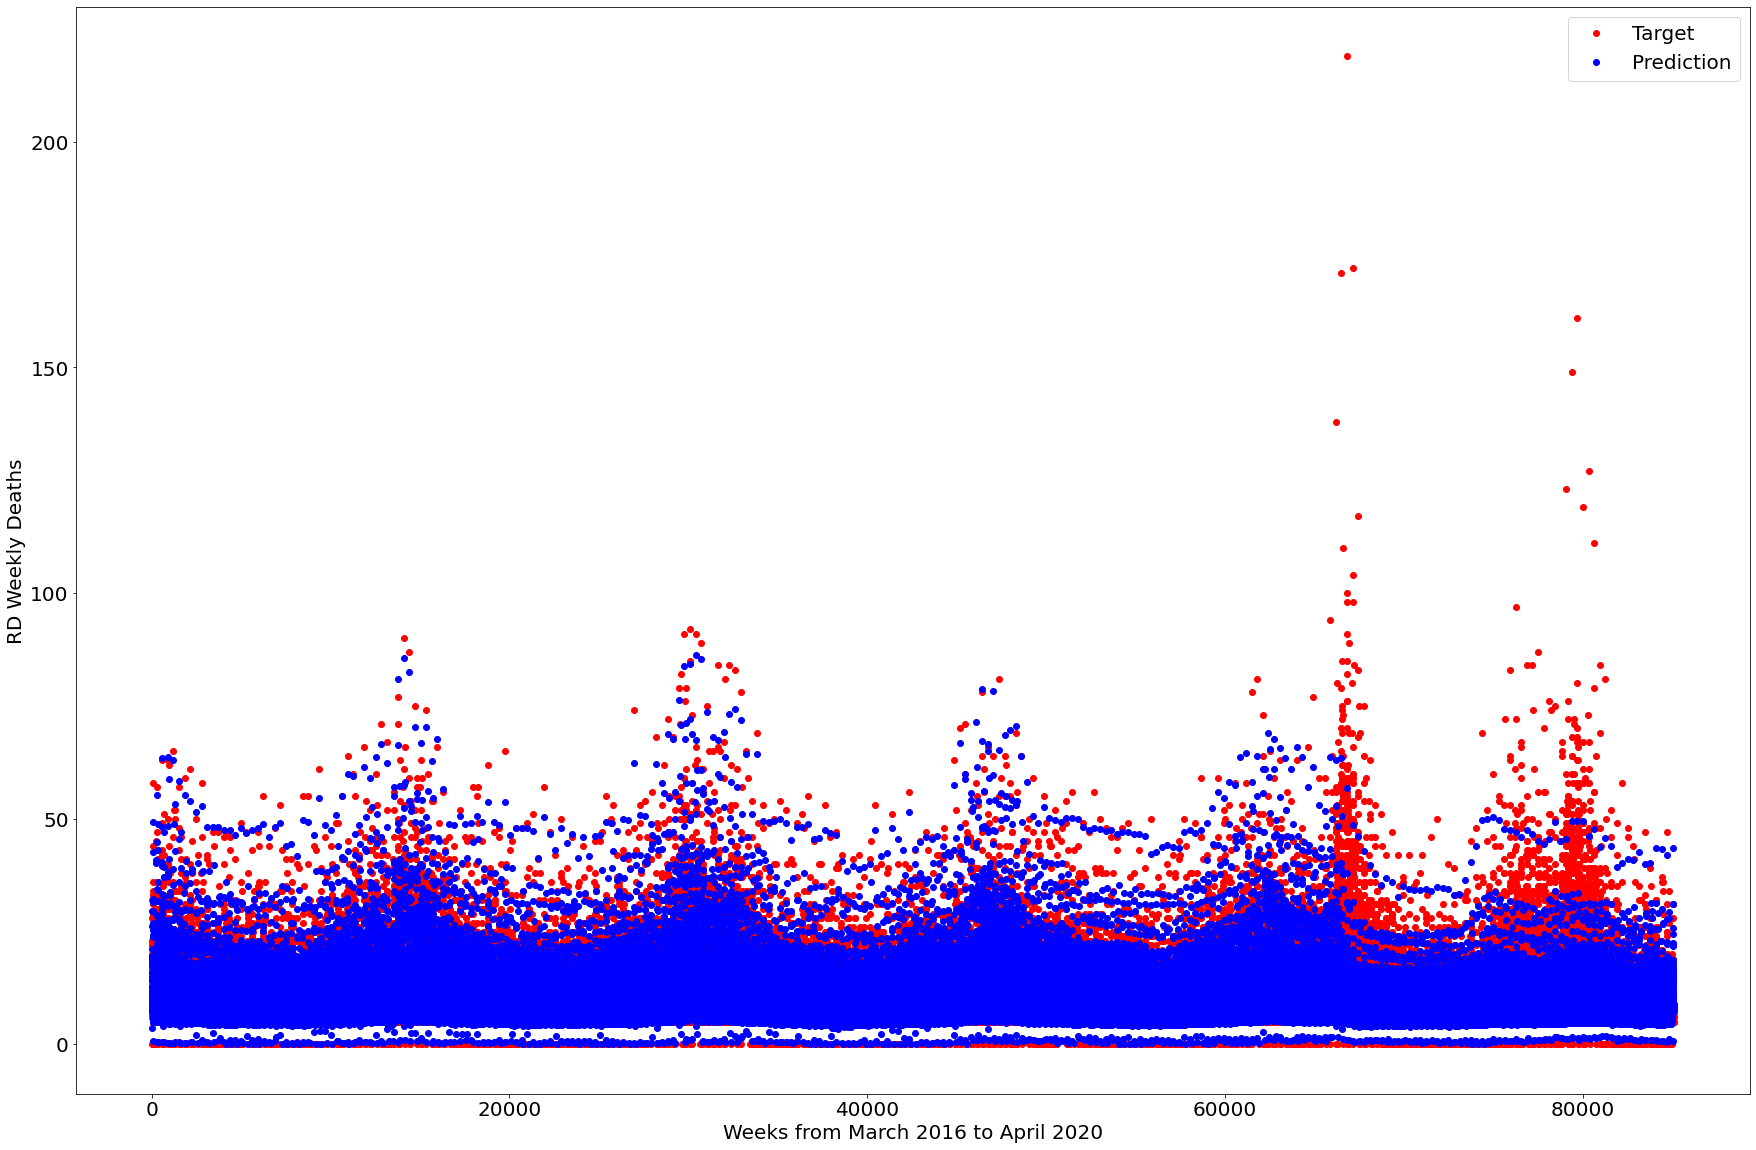

In [60]:
# create visual, plotting predicted and actual deaths from respiratory disease

plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams.update({'font.size': 20})
plt.plot(y, 'ro', RDdeath_predictions, 'bo')
plt.ylabel('RD Weekly Deaths')
plt.xlabel('Weeks from March 2016 to April 2020')
plt.legend(['Target', 'Prediction'])
plt.show()

In [61]:
#create new dataframe with predictions to create visual using dates 
d = pd.DataFrame(RDdeath_predictions)
d["RD_deaths"] = y
d["date_deaths"] = df["date"]
d = d.rename(columns={0:"Predicted_RD_deaths"})
d = d.sort_values(by=['date_deaths'])
d

,Predicted_RD_deaths,RD_deaths,date_deaths
0,7.713268,9,2016-03-18
213,9.795321,8,2016-03-18
212,7.109149,6,2016-03-18
211,8.933468,10,2016-03-18
210,6.564693,8,2016-03-18
...,...,...,...
84881,6.402872,5,2021-05-21
84880,5.584326,5,2021-05-21
84879,10.210536,10,2021-05-21
84886,5.622577,5,2021-05-21


<AxesSubplot:xlabel='date_deaths', ylabel='Predicted_RD_deaths'>

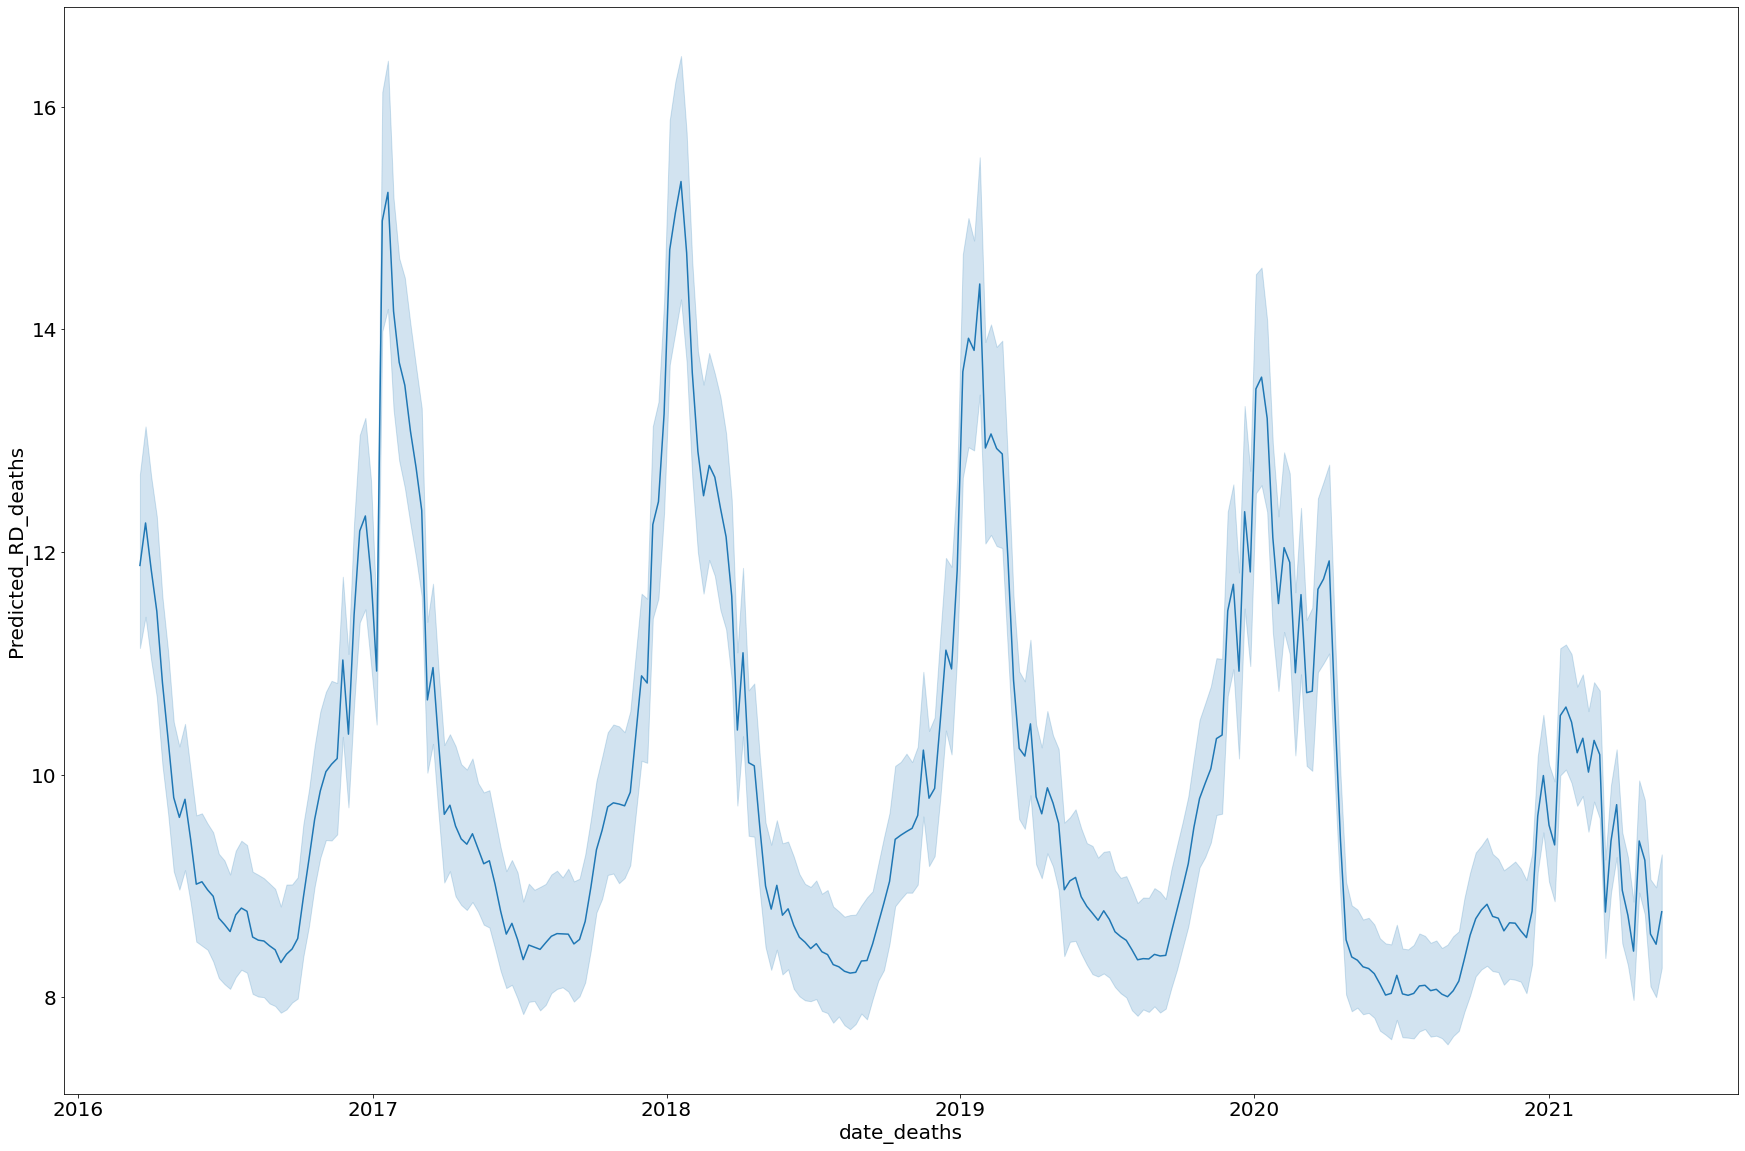

In [65]:
#create visual showing lineplot of predictions
plt.rcParams["figure.figsize"] = (30,20)
sns.lineplot(data=d, x="date_deaths", y="Predicted_RD_deaths")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


''

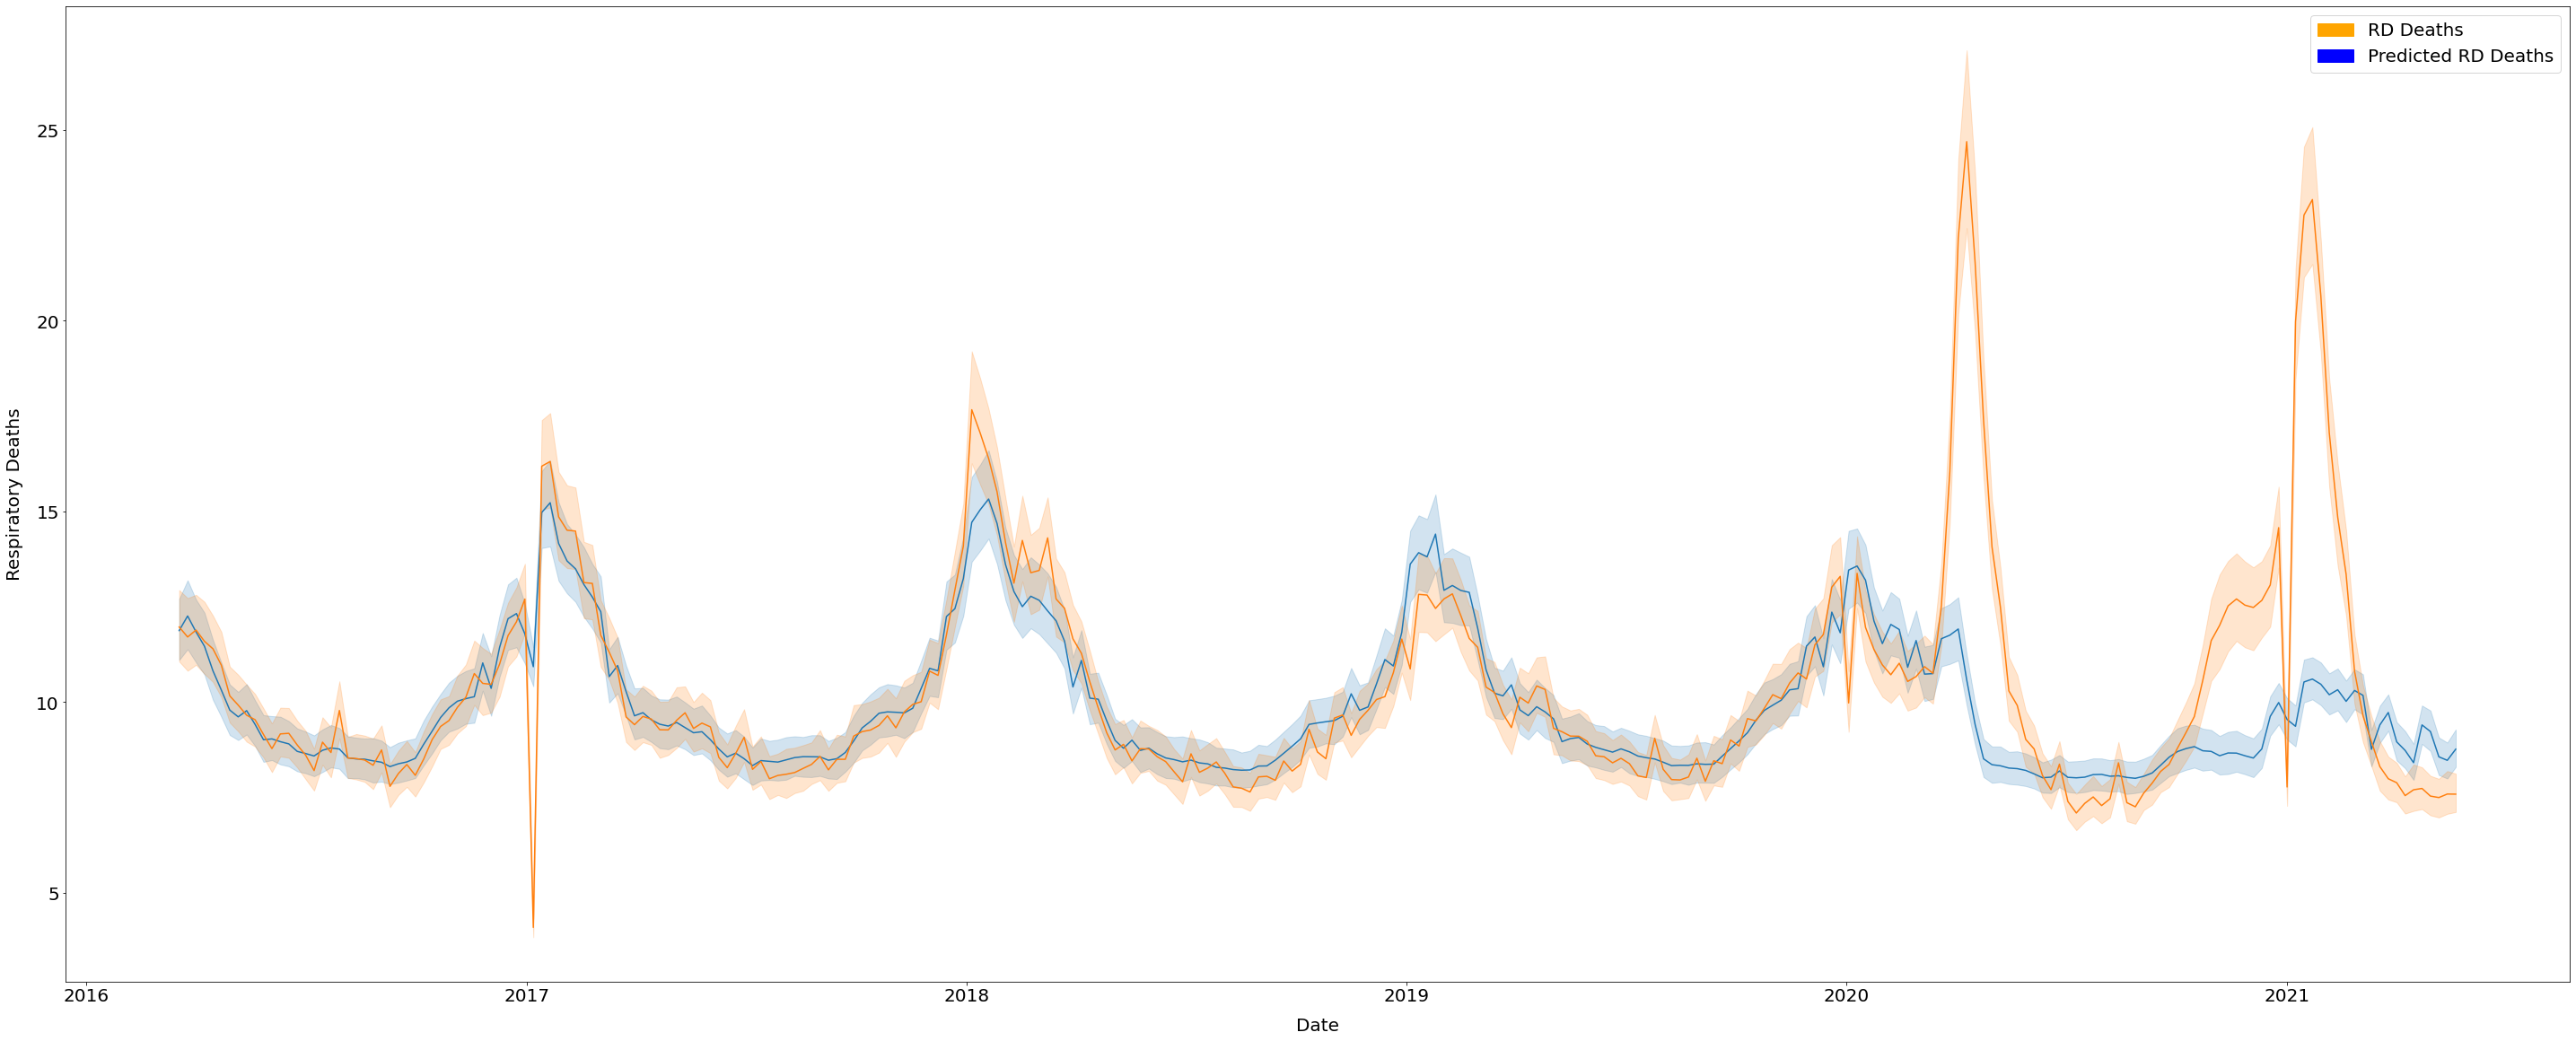

In [66]:
#create visual showing lineplot both predictions and target

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='orange', label='RD Deaths')
blue_patch = mpatches.Patch(color='blue', label='Predicted RD Deaths')

plt.rcParams["figure.figsize"] = (50,20)
sns.lineplot(data=d, x="date_deaths", y="Predicted_RD_deaths")
sns.lineplot(data=d, x="date_deaths", y="RD_deaths")
plt.ylabel("Respiratory Deaths", labelpad=14)
plt.xlabel("Date", labelpad=14)

plt.legend(handles=[red_patch, blue_patch]);

# Seaborn Save Plot:
plt.savefig('coughsAllinputs.eps', format='eps', bbox_inches="tight")
;

In [69]:
#feature importance on model "op_rf" inbuilt to scikit-learn python library for random forest - run on training data
op_rf.feature_importances_

array([0.00909417, 0.01863077, 0.02521939, 0.01555737, 0.03206582,
       0.03151524, 0.01393419, 0.02587483, 0.01916761, 0.0436832 ,
       0.0463703 , 0.00493841, 0.00361974, 0.00754575, 0.00752343,
       0.00252178, 0.00205439, 0.00230401, 0.00299702, 0.01220075,
       0.0077631 , 0.01187847, 0.05959957, 0.07887361, 0.11664145,
       0.13827777, 0.00836117, 0.00350479, 0.00314525, 0.01450141,
       0.01550298, 0.01630057, 0.02420268, 0.00485036, 0.00586389,
       0.00477481, 0.00664922, 0.00558963, 0.00422965, 0.0089783 ,
       0.00653452, 0.00783255, 0.00961596, 0.00440447, 0.00926896,
       0.00758184, 0.00504081, 0.01063937, 0.0132612 , 0.00421398,
       0.01580005, 0.00124342, 0.00201244, 0.01176935, 0.0127872 ,
       0.01168704])

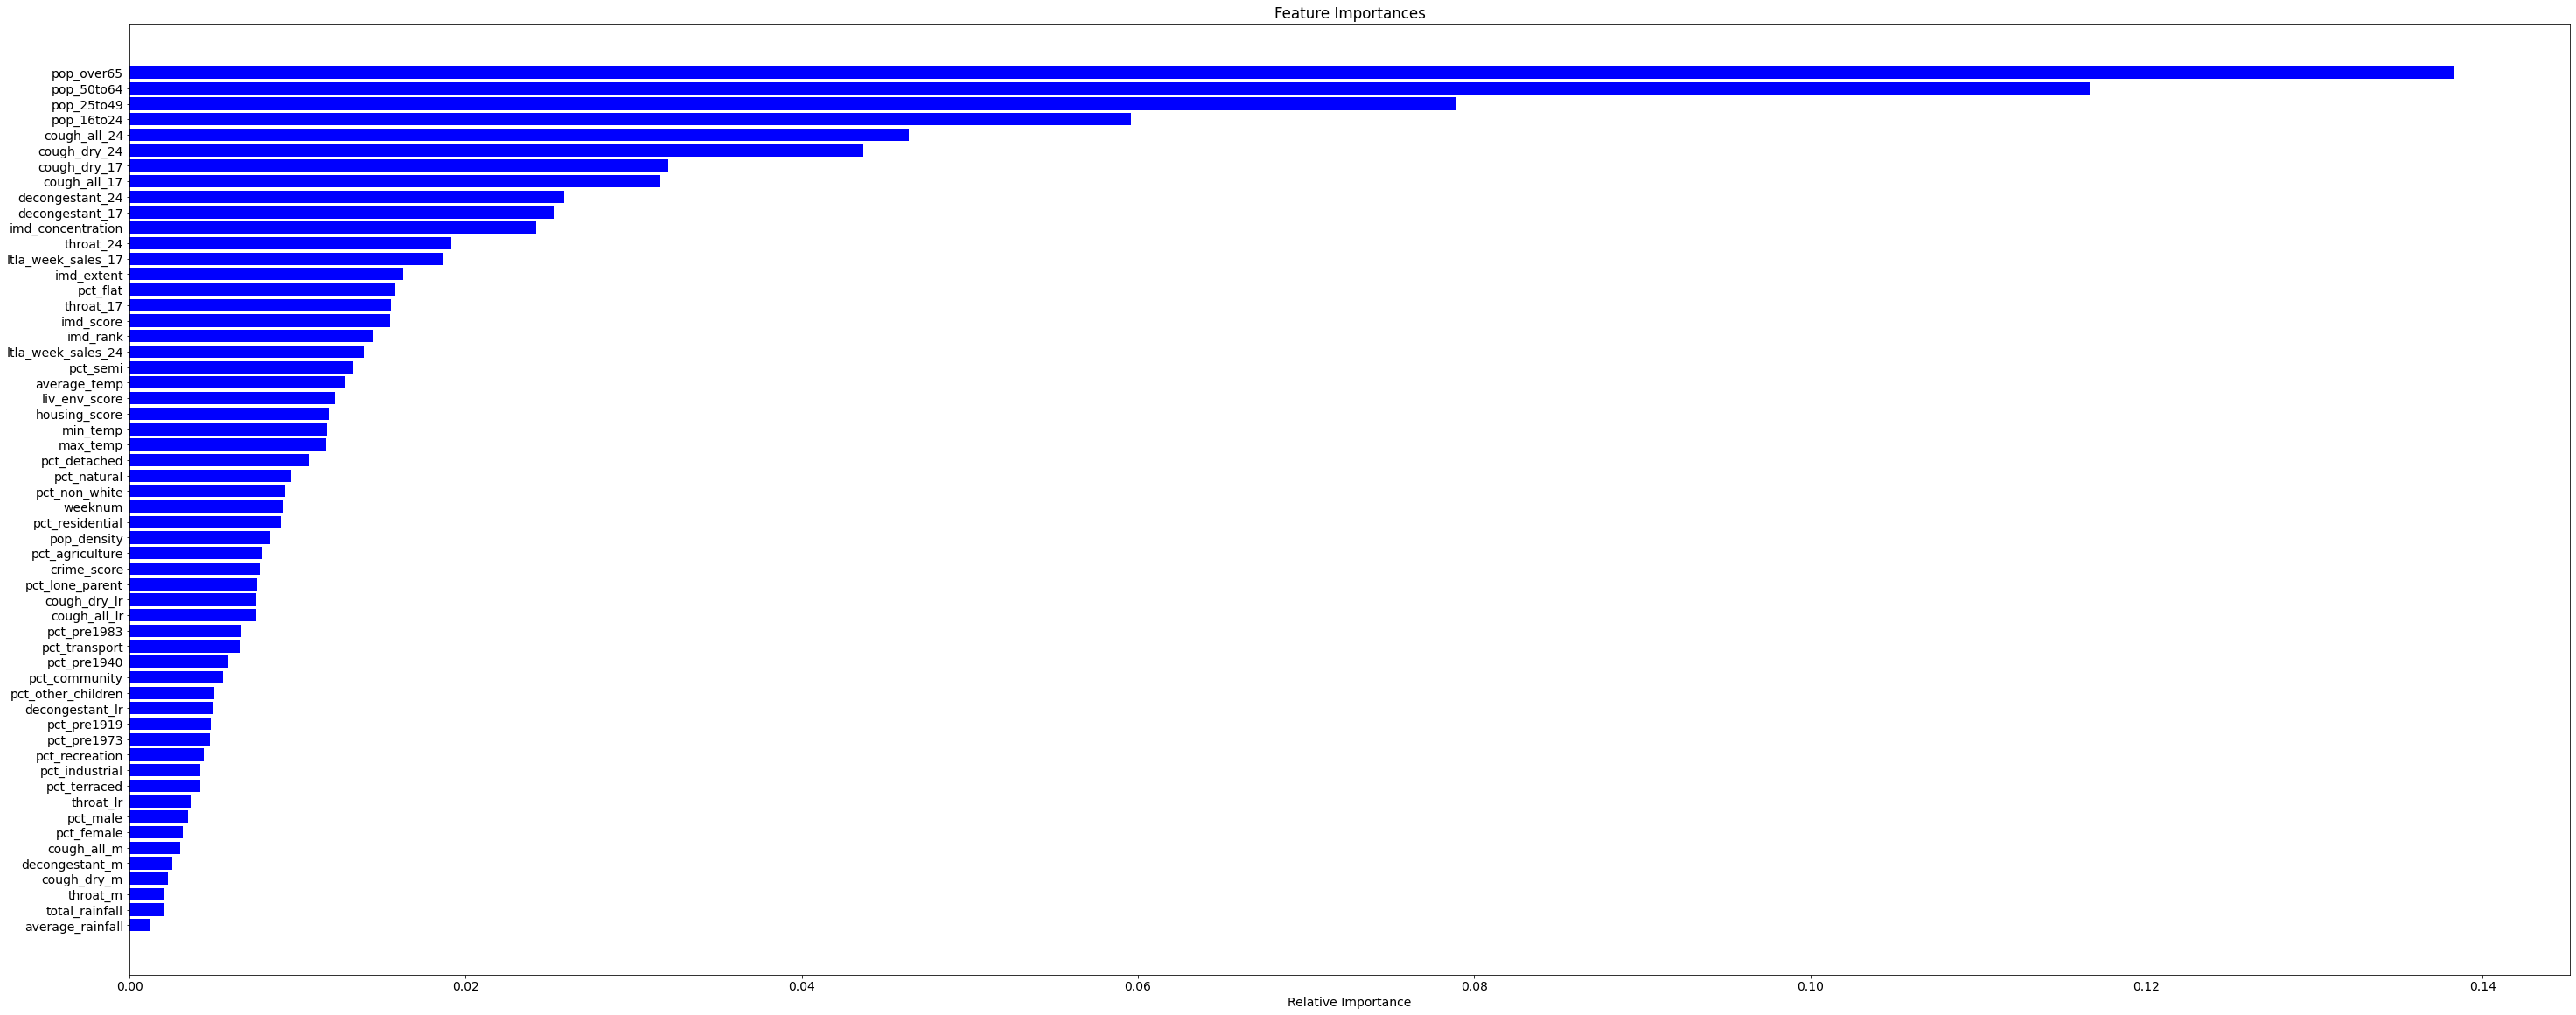

In [68]:
#visual feature importance
importances = op_rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.rcParams.update({'font.size': 14})
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [69]:
#import permutation importance variable importance tool - run on training data
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(op_rf, X_train, y_train)

Text(0.5, 0, 'Permutation Importance')

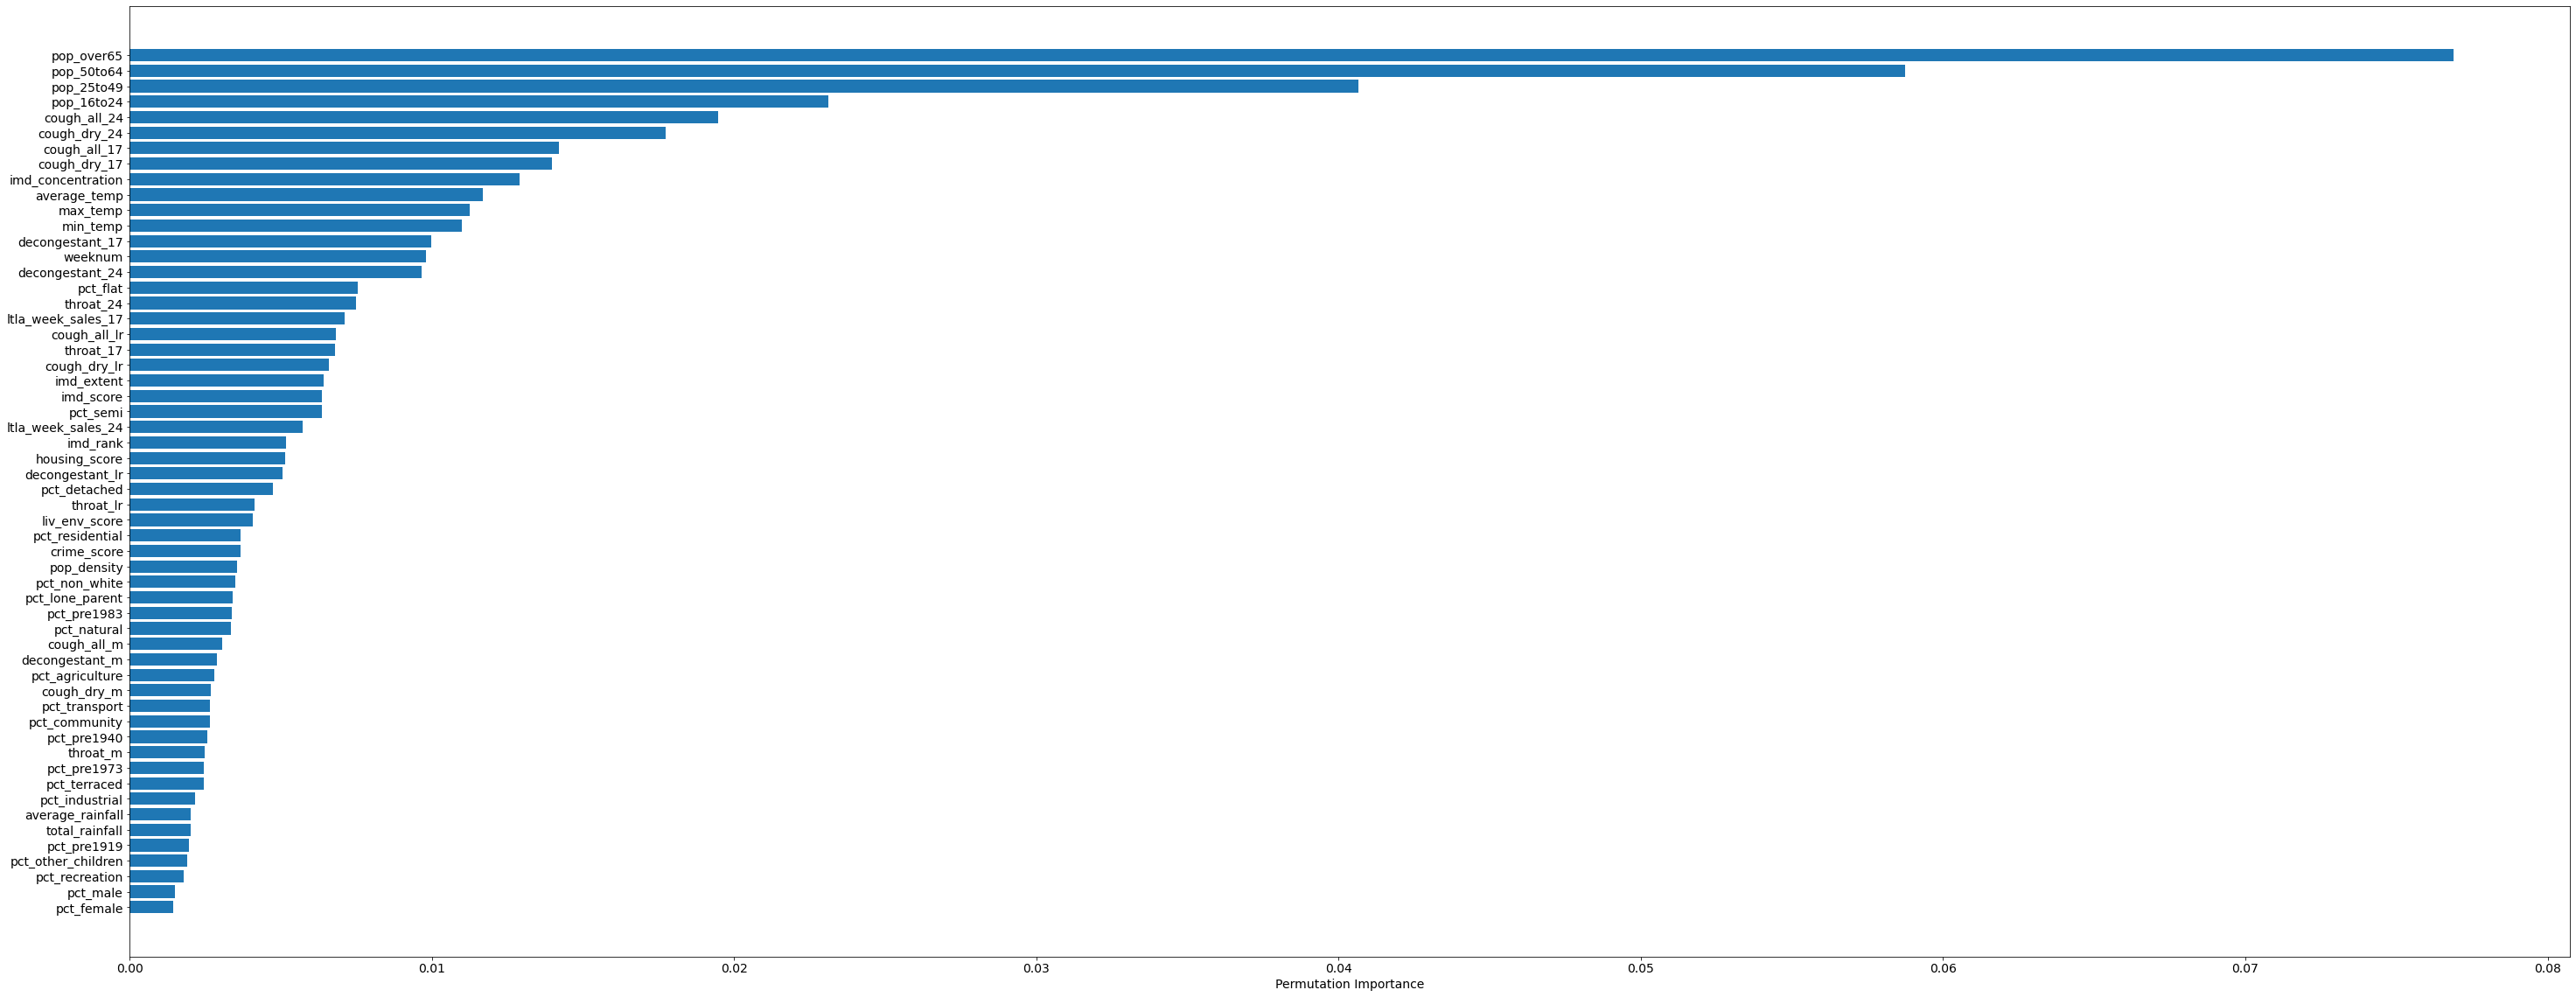

In [70]:
#visual for permutation importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [73]:
#run again to see if differences between different instance of op_rf
perm_importance = permutation_importance(op_rf, X_train, y_train)

Text(0.5, 0, 'Permutation Importance')

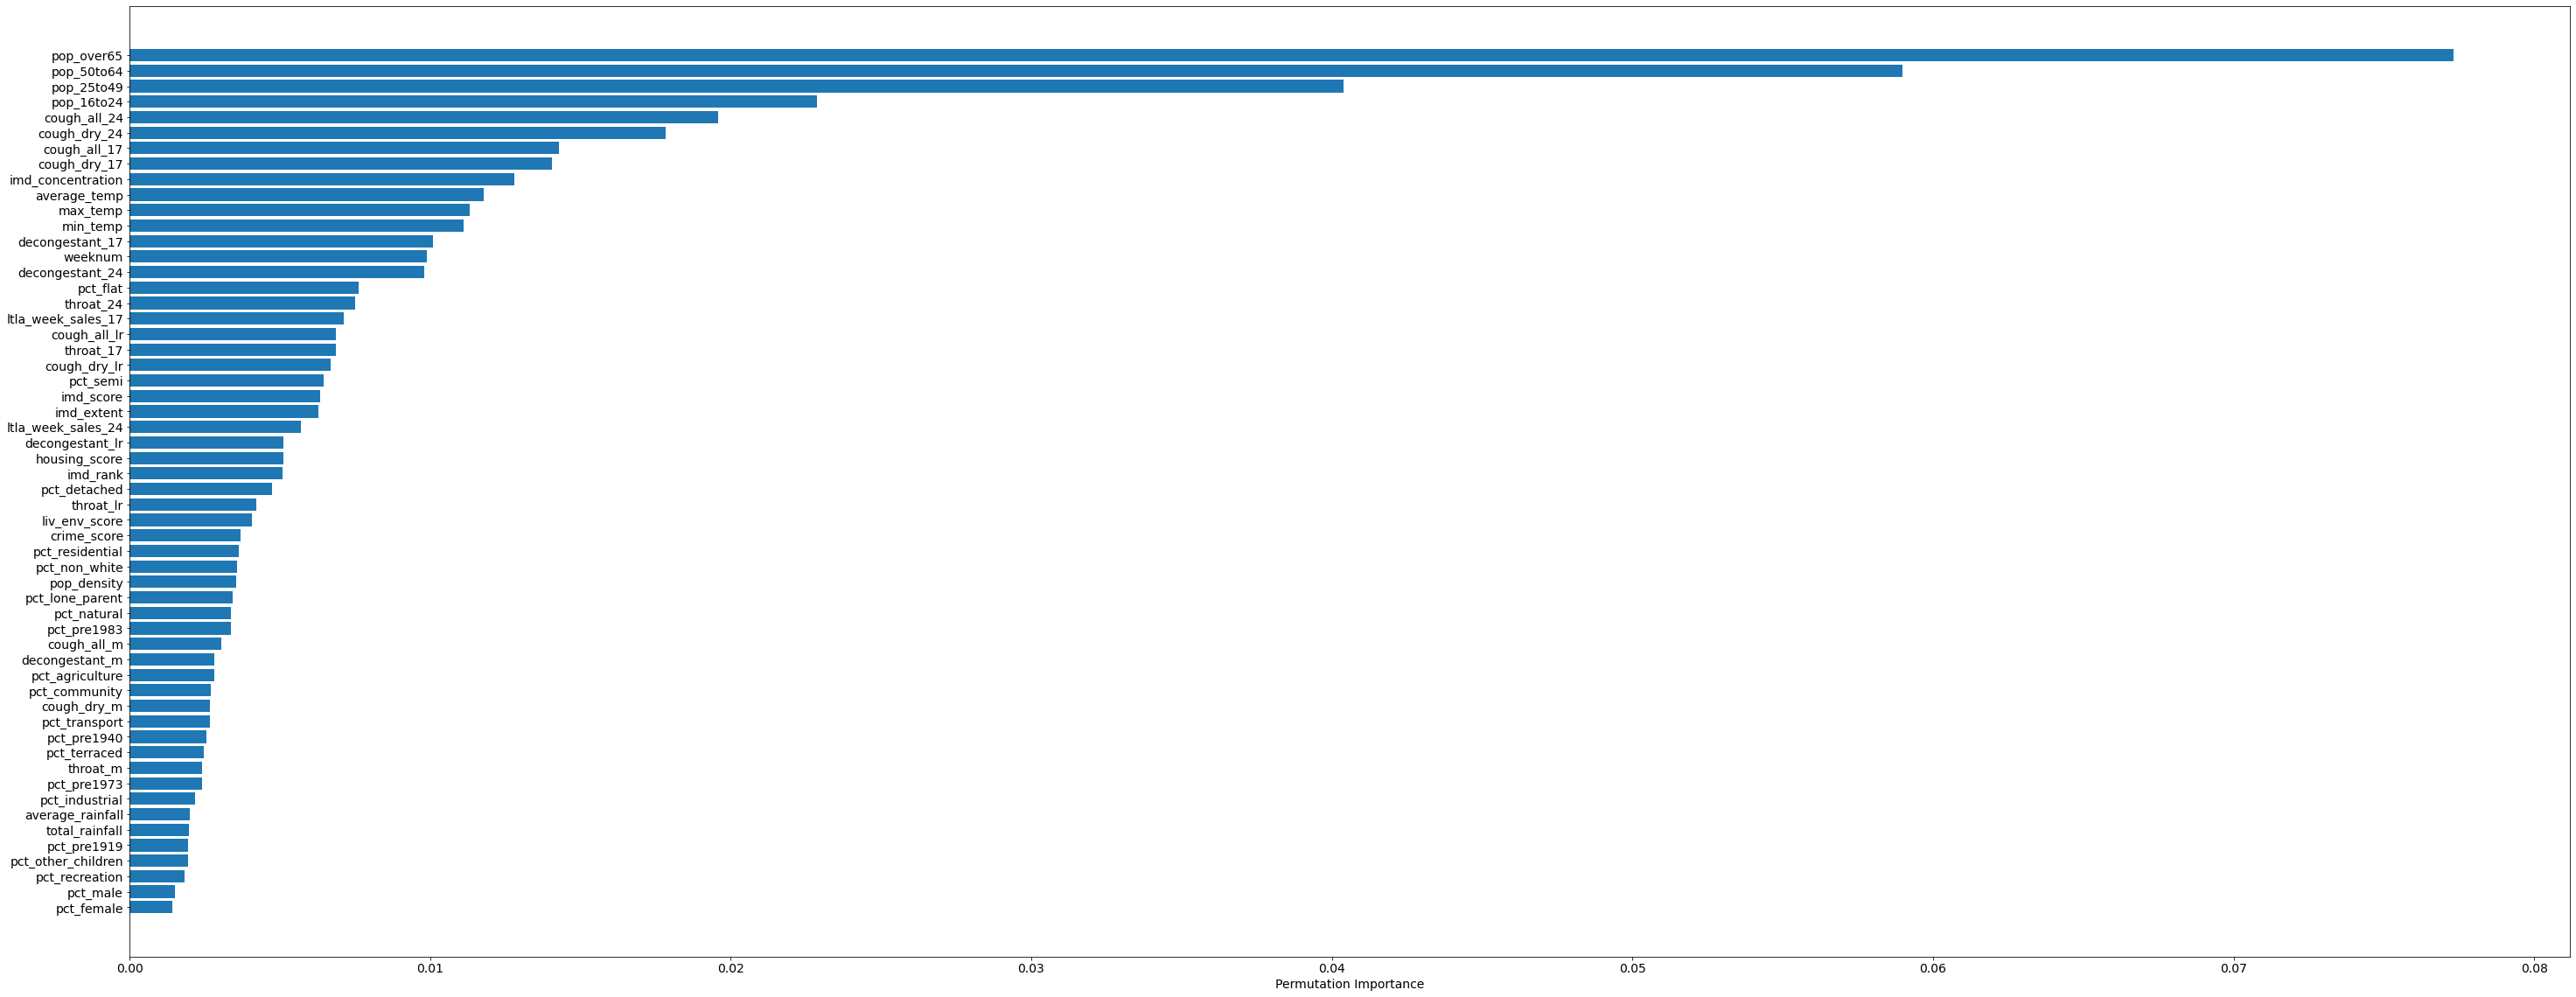

In [74]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [35]:
#import SHAP(SHapley Addictive exPlanations) variable importance tool
import shap

  0%|          | 0/10 [00:00<?, ?it/s]

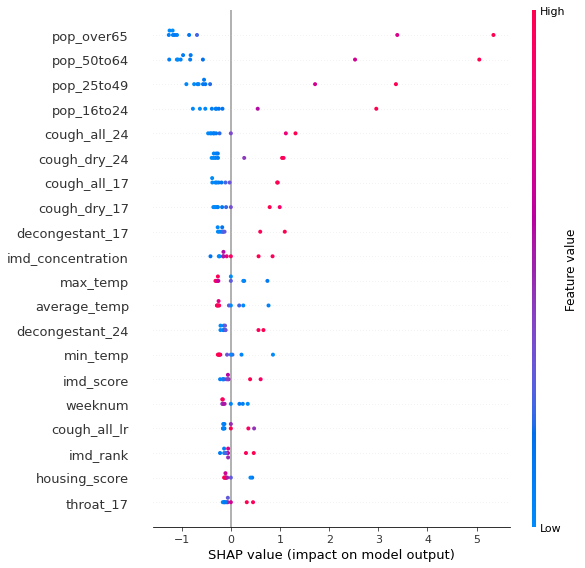

In [76]:
#SHAP very computationally expensive - run on sample of 10 (check its working), 100, 1000 (compare to see if major changes between two)
X_train_shap = shap.sample(X_train, 10)
explainer = shap.KernelExplainer(op_rf.predict, X_train_shap)
shap_values = explainer.shap_values(X_train_shap)
shap.summary_plot(shap_values, X_train_shap)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

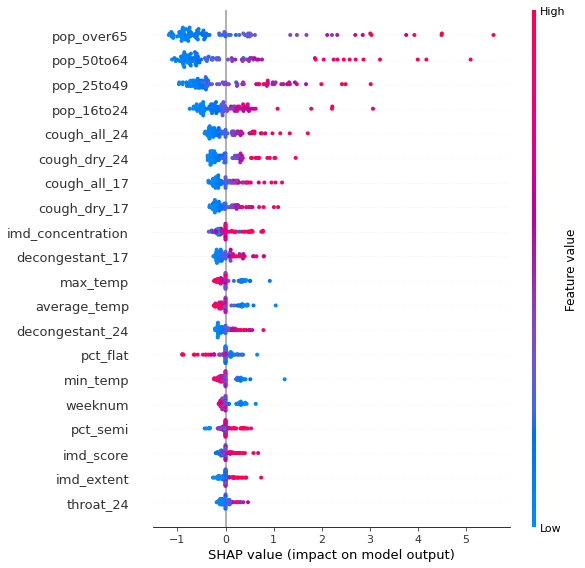

In [77]:
X_train_shap = shap.sample(X_train, 100)
explainer = shap.KernelExplainer(op_rf.predict, X_train_shap)
shap_values = explainer.shap_values(X_train_shap)
shap.summary_plot(shap_values, X_train_shap)
plt.show()

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

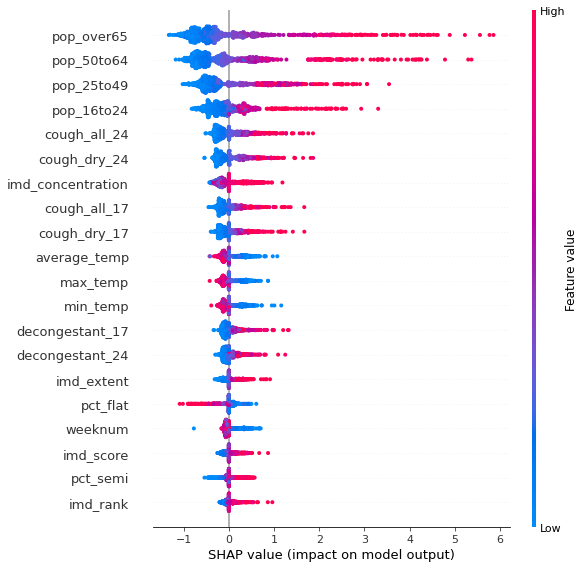

In [33]:
X_train_shap = shap.sample(X_train, 1000)
explainer = shap.KernelExplainer(op_rf.predict, X_train_shap)
shap_values = explainer.shap_values(X_train_shap)
shap.summary_plot(shap_values, X_train_shap)
plt.show()